In [1]:
# Install required packages
!pip install -q transformers torch sentencepiece


[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from transformers import MarianMTModel, MarianTokenizer
import torch

## Load Pretrained Model and Tokenizer
 
We'll use the Helsinki-NLP models which are pretrained for various language pairs. For Hindi to English, we'll use the Helsinki-NLP/opus-mt-hi-en model.

In [3]:
# Initialize the model and tokenizer for Hindi to English translation
model_name = "Helsinki-NLP/opus-mt-hi-en"

# Load the tokenizer
tokenizer = MarianTokenizer.from_pretrained(model_name)

# Load the model
model = MarianMTModel.from_pretrained(model_name)

# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

print(f"Model loaded on {device}")

c:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Model loaded on cuda


## Create Translation Function
Let's create a helper function to handle the translation process. This function will:

1. Tokenize the input text
2. Generate translation
3. Decode the output tokens back to text



In [4]:
def translate_hindi_to_english(text):
    """
    Translate Hindi text to English using the pretrained model
    
    Args:
        text (str): Hindi text to be translated
        
    Returns:
        str: Translated English text
    """
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    
    # Generate translation
    with torch.no_grad():
        outputs = model.generate(**inputs)
    
    # Decode the output tokens to text
    translated_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    
    return translated_text[0]

In [5]:
# Example Hindi sentences
hindi_sentences = [
    "यह एक उदाहरण वाक्य है।",
    "मुझे पाइथन प्रोग्रामिंग पसंद है।",
    "आज मौसम बहुत अच्छा है।",
    "क्या आप अंग्रेजी बोलते हैं?",
    "यह मॉडल हिंदी से अंग्रेजी में अनुवाद करता है।"
]

# Translate each sentence
for sentence in hindi_sentences:
    translation = translate_hindi_to_english(sentence)
    print(f"Hindi: {sentence}")
    print(f"English: {translation}")
    print("-" * 50)

Hindi: यह एक उदाहरण वाक्य है।
English: This is an example sentence.
--------------------------------------------------
Hindi: मुझे पाइथन प्रोग्रामिंग पसंद है।
English: I like Python programs.
--------------------------------------------------
Hindi: आज मौसम बहुत अच्छा है।
English: The weather is great today.
--------------------------------------------------
Hindi: क्या आप अंग्रेजी बोलते हैं?
English: Do you speak English?
--------------------------------------------------
Hindi: यह मॉडल हिंदी से अंग्रेजी में अनुवाद करता है।
English: It translates from Model English to English.
--------------------------------------------------


In [6]:
# For better efficiency when translating multiple sentences, we can process them in batches.
def batch_translate_hindi_to_english(texts):
    """
    Translate a batch of Hindi texts to English
    
    Args:
        texts (list): List of Hindi texts to be translated
        
    Returns:
        list: List of translated English texts
    """
    # Tokenize all texts at once
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)
    
    # Generate translations
    with torch.no_grad():
        outputs = model.generate(**inputs)
    
    # Decode all outputs
    translated_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    
    return translated_texts

# Example batch translation
hindi_batch = [
    "मेरा नाम राहुल है।",
    "मैं भारत में रहता हूँ।",
    "आप कैसे हैं?",
    "यह एक अच्छा दिन है।"
]

english_translations = batch_translate_hindi_to_english(hindi_batch)

for hindi, english in zip(hindi_batch, english_translations):
    print(f"Hindi: {hindi}")
    print(f"English: {english}")
    print("-" * 50)

Hindi: मेरा नाम राहुल है।
English: My name is Rahul.
--------------------------------------------------
Hindi: मैं भारत में रहता हूँ।
English: I live in India.
--------------------------------------------------
Hindi: आप कैसे हैं?
English: How are you?
--------------------------------------------------
Hindi: यह एक अच्छा दिन है।
English: It's a good day.
--------------------------------------------------


In [7]:
# import os

# # Create directory to save model
# model_dir = "./hindi_english_model"
# os.makedirs(model_dir, exist_ok=True)

# # Save model and tokenizer
# model.save_pretrained(model_dir)
# tokenizer.save_pretrained(model_dir)

# print(f"Model and tokenizer saved to {model_dir}")

In [8]:
# # Load from local directory
# model = MarianMTModel.from_pretrained(model_dir).to(device)
# tokenizer = MarianTokenizer.from_pretrained(model_dir)

# print("Model and tokenizer loaded from local directory")

## Performing Inference

In [10]:
ret = batch_translate_hindi_to_english(["मेरा नाम राहुल है।"])
print(ret[0])

My name is Rahul.


## Evaluating the model

In [34]:
# Install required evaluation metrics packages
!pip install -q evaluate sacrebleu

import evaluate
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:

# Initialize metrics
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")
rouge = evaluate.load("rouge")
chrf = evaluate.load("chrf")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tejas\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tejas\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\tejas\AppData\Roaming\nltk_data...


In [14]:
test_data = [
    {
        "hindi": "यह एक उदाहरण वाक्य है।",
        "reference": "This is an example sentence."
    },
    {
        "hindi": "मुझे पाइथन प्रोग्रामिंग पसंद है।",
        "reference": "I like Python programming."
    },
    {
        "hindi": "आज मौसम बहुत अच्छा है।",
        "reference": "The weather is very nice today."
    },
    {
        "hindi": "क्या आप अंग्रेजी बोलते हैं?",
        "reference": "Do you speak English?"
    },
    {
        "hindi": "यह मॉडल हिंदी से अंग्रेजी में अनुवाद करता है।",
        "reference": "This model translates from Hindi to English."
    },
    {
        "hindi": "मेरा नाम राहुल है।",
        "reference": "My name is Rahul."
    },
    {
        "hindi": "मैं भारत में रहता हूँ।",
        "reference": "I live in India."
    },
    {
        "hindi": "आप कैसे हैं?",
        "reference": "How are you?"
    }
]


In [28]:
results = []

for item in test_data:
    prediction = translate_hindi_to_english(item["hindi"])
    
    # Calculate metrics
    bleu_score = bleu.compute(predictions=[prediction], references=[item["reference"]])["bleu"]
    meteor_score = meteor.compute(predictions=[prediction], references=[item["reference"]])["meteor"]
    rouge_score = rouge.compute(predictions=[prediction], references=[item["reference"]])["rougeL"]
    chrf_score = chrf.compute(predictions=[prediction], references=[item["reference"]])["score"]
    
    results.append({
        "Hindi": item["hindi"],
        "Reference": item["reference"],
        "Prediction": prediction,
        "BLEU": bleu_score,
        "METEOR": meteor_score,
        "ROUGE-L": rouge_score,
        "chrF": chrf_score/100
    })

# Create DataFrame
results_df = pd.DataFrame(results)


In [29]:
print("Translation Results:")
display(results_df)


Translation Results:


,Hindi,Reference,Prediction,BLEU,METEOR,ROUGE-L,chrF
0,यह एक उदाहरण वाक्य है।,This is an example sentence.,This is an example sentence.,1.0,0.997685,1.000000,1.000000
1,मुझे पाइथन प्रोग्रामिंग पसंद है।,I like Python programming.,I like Python programs.,0.0,0.996000,0.750000,0.784709
2,आज मौसम बहुत अच्छा है।,The weather is very nice today.,The weather is great today.,0.0,0.701449,0.727273,0.572774
3,क्या आप अंग्रेजी बोलते हैं?,Do you speak English?,Do you speak English?,1.0,0.996000,1.000000,1.000000
4,यह मॉडल हिंदी से अंग्रेजी में अनुवाद करता है।,This model translates from Hindi to English.,It translates from Model English to English.,0.0,0.703125,0.571429,0.598934
5,मेरा नाम राहुल है।,My name is Rahul.,My name is Rahul.,1.0,0.996000,1.000000,1.000000
6,मैं भारत में रहता हूँ।,I live in India.,I live in India.,1.0,0.996000,1.000000,1.000000
7,आप कैसे हैं?,How are you?,How are you?,1.0,0.992188,1.000000,1.000000


In [30]:
avg_scores = {
    "BLEU": results_df["BLEU"].mean(),
    "METEOR": results_df["METEOR"].mean(),
    "ROUGE-L": results_df["ROUGE-L"].mean(),
    "chrF": results_df["chrF"].mean()
}

print("\nAverage Scores:")
display(pd.DataFrame([avg_scores]))



Average Scores:


,BLEU,METEOR,ROUGE-L,chrF
0,0.625,0.922306,0.881088,0.869552


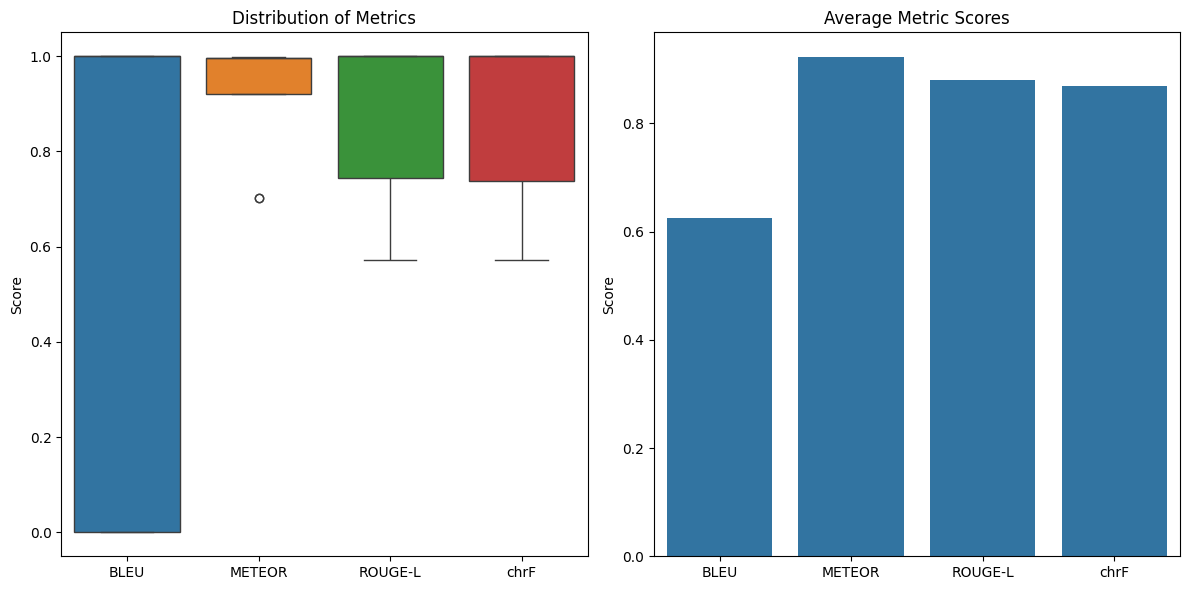

In [31]:
plt.figure(figsize=(12, 6))

# Boxplot of all metrics
plt.subplot(1, 2, 1)
sns.boxplot(data=results_df[["BLEU", "METEOR", "ROUGE-L", "chrF"]])
plt.title("Distribution of Metrics")
plt.ylabel("Score")

# Bar plot of average scores
plt.subplot(1, 2, 2)
sns.barplot(x=list(avg_scores.keys()), y=list(avg_scores.values()))
plt.title("Average Metric Scores")
plt.ylabel("Score")

plt.tight_layout()
plt.show()


In [32]:
print("\nSample Translations:")
sample_idx = 4  # Change this to see different examples
print(f"Hindi: {results_df.iloc[sample_idx]['Hindi']}")
print(f"Reference: {results_df.iloc[sample_idx]['Reference']}")
print(f"Prediction: {results_df.iloc[sample_idx]['Prediction']}")
print(f"BLEU Score: {results_df.iloc[sample_idx]['BLEU']:.5f}")



Sample Translations:
Hindi: यह मॉडल हिंदी से अंग्रेजी में अनुवाद करता है।
Reference: This model translates from Hindi to English.
Prediction: It translates from Model English to English.
BLEU Score: 0.00000


In [45]:
# Install required packages
!pip install -q evaluate sacrebleu datasets
!pip install -q --upgrade evaluate

import evaluate
import pandas as pd
import matplotlib.pyplot as plt
from evaluate import load
import numpy as np





[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [65]:
test_data = [
    {"hindi": "यह एक उदाहरण वाक्य है।", "reference": ["This is an example sentence."]},
    {"hindi": "मुझे पाइथन प्रोग्रामिंग पसंद है।", "reference": ["I like Python programming."]},
    {"hindi": "आज मौसम बहुत अच्छा है।", "reference": ["The weather is very nice today.", "Today the weather is very good."]},
    {"hindi": "क्या आप अंग्रेजी बोलते हैं?", "reference": ["Do you speak English?"]},
    {"hindi": "यह मॉडल हिंदी से अंग्रेजी में अनुवाद करता है।", "reference": ["This model translates from Hindi to English."]},
    {"hindi": "मेरा नाम राहुल है।", "reference": ["My name is Rahul."]},
    {"hindi": "मैं भारत में रहता हूँ।", "reference": ["I live in India.", "I reside in India."]},
    {"hindi": "आप कैसे हैं?", "reference": ["How are you?"]},
    {"hindi": "धन्यवाद", "reference": ["Thank you"]},
    {"hindi": "मुझे मदद की ज़रूरत है", "reference": ["I need help"]},
    {"hindi": "यह कितना का है?", "reference": ["How much does this cost?"]},
    {"hindi": "मैं समझ गया", "reference": ["I understand", "I got it"]},
    {"hindi": "कृपया धीरे बोलिए", "reference": ["Please speak slowly"]},
    {"hindi": "मुझे नहीं पता", "reference": ["I don't know"]},
    {"hindi": "आपका स्वागत है", "reference": ["You're welcome"]},
    {"hindi": "मेरे पास एक प्रश्न है", "reference": ["I have a question"]},
    {"hindi": "समय क्या हुआ है?", "reference": ["What time is it?"]},
    {"hindi": "मैं भूखा हूँ", "reference": ["I am hungry"]},
    {"hindi": "यहाँ कैसे पहुँचे?", "reference": ["How to reach here?"]},
    {"hindi": "मुझे यह चाहिए", "reference": ["I want this"]},
    {"hindi": "बाथरूम कहाँ है?", "reference": ["Where is the bathroom?"]},
    {"hindi": "मुझे दर्द हो रहा है", "reference": ["I am in pain"]},
    {"hindi": "यह बहुत अच्छा है", "reference": ["This is very good"]},
    {"hindi": "मैं थक गया हूँ", "reference": ["I am tired"]},
    {"hindi": "कल मिलते हैं", "reference": ["See you tomorrow"]},
    {"hindi": "मुझे आपकी मदद चाहिए", "reference": ["I need your help"]},
    {"hindi": "यह कैसे काम करता है?", "reference": ["How does this work?"]},
    {"hindi": "मैं खो गया हूँ", "reference": ["I am lost"]},
    {"hindi": "मेरा दिन अच्छा रहा", "reference": ["I had a good day"]},
    {"hindi": "क्या आप मुझे समझते हैं?", "reference": ["Do you understand me?"]},
    {"hindi": "मैं बस से यात्रा करना चाहता हूँ", "reference": ["I want to travel by bus"]},
    {"hindi": "यह गलत है", "reference": ["This is wrong"]},
    {"hindi": "मुझे एक कमरा चाहिए", "reference": ["I need a room"]},
    {"hindi": "मैं खुश हूँ", "reference": ["I am happy"]},
    {"hindi": "क्या यहाँ WiFi है?", "reference": ["Is there WiFi here?"]},
    {"hindi": "मुझे पानी चाहिए", "reference": ["I need water"]},
    {"hindi": "यह मजेदार है", "reference": ["This is fun"]},
    {"hindi": "मैं नया हूँ यहाँ", "reference": ["I am new here"]},
    {"hindi": "क्या आप फिर से कह सकते हैं?", "reference": ["Can you say that again?"]},
    {"hindi": "मुझे टिकट चाहिए", "reference": ["I need a ticket"]},
    {"hindi": "यह बहुत महंगा है", "reference": ["This is too expensive"]},
    {"hindi": "मैं ठीक हूँ", "reference": ["I am fine"]},
    {"hindi": "क्या आप मेरी मदद कर सकते हैं?", "reference": ["Can you help me?"]},
    {"hindi": "मुझे डॉक्टर चाहिए", "reference": ["I need a doctor"]},
    {"hindi": "मैं भारत से हूँ", "reference": ["I am from India"]},
    {"hindi": "यह कहाँ है?", "reference": ["Where is this?"]},
    {"hindi": "मुझे समय चाहिए", "reference": ["I need time"]},
    {"hindi": "क्या आप हिंदी बोलते हैं?", "reference": ["Do you speak Hindi?"]},
    {"hindi": "मैं सीख रहा हूँ", "reference": ["I am learning"]},
    {"hindi": "यह सुंदर है", "reference": ["This is beautiful"]}
]

In [61]:
test_data = [
    {"hindi": "हालांकि मौसम खराब होने के बावजूद, हमने पिकनिक जाने का निर्णय लिया क्योंकि बच्चों को बहुत उत्साहित देखना मुश्किल था।",
     "reference": ["Despite the bad weather, we decided to go for the picnic because it was hard to see the children so excited."]},

    {"hindi": "जब तक आप इस परियोजना को पूरा करने के लिए आवश्यक सभी संसाधनों की व्यवस्था नहीं करते, तब तक कार्य शुरू करने का कोई मतलब नहीं है।",
     "reference": ["There's no point in starting the work until you arrange all the resources needed to complete this project."]},

    {"hindi": "उसने मुझे बताया कि वह पिछले सप्ताह से अस्वस्थ महसूस कर रहा था, लेकिन डॉक्टर के पास जाने से बचता रहा क्योंकि उसे लगता था कि यह सिर्फ मौसमी बुखार है।",
     "reference": ["He told me he had been feeling unwell since last week, but avoided going to the doctor because he thought it was just seasonal fever."]},

    {"hindi": "यदि आप समय पर दस्तावेज़ जमा नहीं करते हैं, तो आपको अतिरिक्त शुल्क का भुगतान करना पड़ सकता है, जो कि मूल राशि का लगभग पच्चीस प्रतिशत तक हो सकता है।",
     "reference": ["If you don't submit the documents on time, you may have to pay an additional fee that could be up to twenty-five percent of the original amount."]},

    {"hindi": "जिस तरह से उसने इस जटिल समस्या को हल किया, वह वास्तव में प्रशंसनीय था क्योंकि उसने न केवल तकनीकी ज्ञान बल्कि रचनात्मक सोच का भी प्रदर्शन किया।",
     "reference": ["The way he solved this complex problem was truly admirable as he demonstrated not only technical knowledge but also creative thinking."]},

    {"hindi": "हमें यह समझना चाहिए कि केवल कड़ी मेहनत ही सफलता की गारंटी नहीं है; सही दिशा में किया गया प्रयास और समय पर लिए गए निर्णय भी उतने ही महत्वपूर्ण हैं।",
     "reference": ["We must understand that hard work alone doesn't guarantee success; effort in the right direction and timely decisions are equally important."]},

    {"hindi": "जब मैंने उस पुराने घर के अंदर कदम रखा, तो मुझे लगा जैसे समय थम सा गया हो, क्योंकि हर चीज वैसी ही थी जैसी मैंने बचपन में देखी थी।",
     "reference": ["When I stepped inside that old house, I felt as if time had stood still, because everything was exactly as I had seen it in my childhood."]},

    {"hindi": "यद्यपि नए नियमों का उद्देश्य सिस्टम में पारदर्शिता लाना है, लेकिन कई कर्मचारियों का मानना है कि यह केवल प्रक्रियाओं को और अधिक जटिल बना देगा।",
     "reference": ["Although the new rules aim to bring transparency to the system, many employees believe it will only make the procedures more complicated."]},

    {"hindi": "उसने अपनी आँखों में आँसू छुपाते हुए कहा कि वह इस निर्णय से पूरी तरह सहमत नहीं है, लेकिन टीम के हित में इसे स्वीकार करने को तैयार है।",
     "reference": ["Hiding tears in her eyes, she said she doesn't completely agree with this decision but is willing to accept it for the team's benefit."]},

    {"hindi": "जब तक हम इस मुद्दे के ऐतिहासिक संदर्भ और वर्तमान परिस्थितियों को नहीं समझते, तब तक हम कोई उचित समाधान नहीं निकाल सकते।",
     "reference": ["Until we understand the historical context and current circumstances of this issue, we can't come up with any proper solution."]},

    {"hindi": "वह किताब जो मैंने पिछले सप्ताह पुस्तकालय से ली थी, वह इतनी रोचक निकली कि मैं इसे खत्म किए बिना सो नहीं पाया, हालांकि मुझे अगले दिन जल्दी उठना था।",
     "reference": ["The book I borrowed from the library last week turned out to be so interesting that I couldn't sleep without finishing it, although I had to wake up early the next day."]},

    {"hindi": "इस शोध परियोजना को पूरा करने के लिए, हमें न केवल पर्याप्त धन की आवश्यकता होगी, बल्कि उन विशेषज्ञों का सहयोग भी चाहिए होगा जो इस क्षेत्र में कम से कम दस वर्षों का अनुभव रखते हों।",
     "reference": ["To complete this research project, we will need not only sufficient funds but also the cooperation of experts who have at least ten years of experience in this field."]},

    {"hindi": "जिस तरह से उसने इस संकट की स्थिति को संभाला, वह इस बात का प्रमाण था कि वह न केवल एक कुशल पेशेवर है बल्कि तनाव में शांत रहने की अद्भुत क्षमता भी रखता है।",
     "reference": ["The way he handled this crisis situation was proof that he is not only a skilled professional but also has an amazing ability to remain calm under pressure."]},

    {"hindi": "हमें यह स्वीकार करना चाहिए कि शिक्षा प्रणाली में सुधार एक जटिल प्रक्रिया है जिसमें न केवल पाठ्यक्रम बदलने की आवश्यकता है, बल्कि शिक्षण विधियों और मूल्यांकन प्रणाली में भी बदलाव लाने की जरूरत है।",
     "reference": ["We must admit that reforming the education system is a complex process that requires not only changing the curriculum but also modifying teaching methods and evaluation systems."]},

    {"hindi": "जब मैंने उसके चेहरे पर वह अजीब सी अभिव्यक्ति देखी, तो मुझे तुरंत एहसास हुआ कि मैंने कुछ गलत कह दिया है, लेकिन तब तक बहुत देर हो चुकी थी।",
     "reference": ["When I saw that strange expression on his face, I immediately realized I had said something wrong, but by then it was too late."]},

    {"hindi": "इस नई तकनीक को अपनाने के फैसले के पीछे मुख्य कारण यह है कि यह न केवल उत्पादकता बढ़ाएगी बल्कि लंबे समय में परिचालन लागत को भी कम कर देगा, हालांकि प्रारंभिक निवेश काफी अधिक है।",
     "reference": ["The main reason behind the decision to adopt this new technology is that it will not only increase productivity but also reduce operational costs in the long run, although the initial investment is quite high."]},

    {"hindi": "उसने मुझे यह समझाने की कोशिश की कि क्यों उसका प्रस्ताव मेरे विचार से बेहतर था, लेकिन मैं इस बात से सहमत नहीं हो पा रहा था क्योंकि मुझे लगता था कि उसके तर्कों में कुछ तार्किक खामियाँ थीं।",
     "reference": ["He tried to explain to me why his proposal was better than my idea, but I couldn't agree because I thought there were some logical flaws in his arguments."]},

    {"hindi": "जब तक हम इस समस्या के मूल कारणों को नहीं समझते और उन्हें दूर नहीं करते, तब तक हम केवल लक्षणों का इलाज कर रहे होंगे और समस्या बार-बार सामने आती रहेगी।",
     "reference": ["Until we understand and address the root causes of this problem, we'll only be treating the symptoms and the issue will keep recurring."]},

    {"hindi": "वह फिल्म जिसे हमने कल देखा था, वह न केवल मनोरंजक थी बल्कि उसमें एक गहरा सामाजिक संदेश भी था जिसने मुझे यह सोचने पर मजबूर कर दिया कि हम अपने दैनिक जीवन में कितने स्वार्थी हो गए हैं।",
     "reference": ["The movie we watched yesterday was not only entertaining but also had a deep social message that made me think about how selfish we have become in our daily lives."]},

    {"hindi": "इस परियोजना को सफलतापूर्वक पूरा करने के लिए, हमें विभिन्न विभागों के बीच बेहतर समन्वय स्थापित करने की आवश्यकता है, क्योंकि वर्तमान में हो रही देरी का मुख्य कारण संचार की कमी है।",
     "reference": ["To successfully complete this project, we need to establish better coordination between different departments, because the main reason for the current delays is lack of communication."]},

    {"hindi": "जिस तरह से उसने अपने भाषण की शुरुआत की, उससे सभी श्रोताओं का ध्यान तुरंत आकर्षित हो गया, और जब वह बोल रहा था तो आप सुन सकते थे कि पूरा हॉल पूरी तरह से चुप था।",
     "reference": ["The way he began his speech immediately caught all listeners' attention, and when he was speaking you could hear that the entire hall was completely silent."]},

    {"hindi": "हमें यह स्वीकार करना होगा कि पर्यावरण संकट केवल सरकारों या बड़ी कंपनियों की समस्या नहीं है; प्रत्येक व्यक्ति को अपनी जीवनशैली में बदलाव लाने की आवश्यकता है, चाहे वे कितने भी छोटे क्यों न हों।",
     "reference": ["We must admit that the environmental crisis isn't just a problem for governments or big companies; every individual needs to make changes in their lifestyle, no matter how small they may be."]},

    {"hindi": "जब मैंने उस पत्र को पढ़ा जो मुझे बीस साल बाद मिला था, तो मुझे एहसास हुआ कि जिन बातों को मैंने उस समय गंभीरता से नहीं लिया था, वास्तव में वे मेरे जीवन के सबसे महत्वपूर्ण निर्णयों में से एक थीं।",
     "reference": ["When I read that letter which I received after twenty years, I realized that what I hadn't taken seriously at that time was actually one of the most important decisions of my life."]},

    {"hindi": "यद्यपि इस नई नीति के कुछ सकारात्मक पहलू हैं जिन्हें नजरअंदाज नहीं किया जा सकता, लेकिन मेरा मानना है कि इसके कार्यान्वयन के तरीके में कुछ मूलभूत समस्याएं हैं जिन्हें दूर करने की आवश्यकता है।",
     "reference": ["Although this new policy has some positive aspects that cannot be ignored, I believe there are some fundamental problems in its implementation method that need to be addressed."]},

    {"hindi": "उसने मुझे यह बताते हुए कि वह क्यों नाराज थी, अपनी आवाज को नियंत्रित रखने की पूरी कोशिश की, लेकिन मैं उसकी आँखों में आँसू देख सकता था जो उसके वास्तविक भावनाओं को छुपा नहीं पा रहे थे।",
     "reference": ["While telling me why she was upset, she tried hard to keep her voice controlled, but I could see tears in her eyes that couldn't hide her true feelings."]},

    {"hindi": "जब तक हम इस समस्या को विभिन्न दृष्टिकोणों से नहीं देखते और सभी संभावित परिणामों पर विचार नहीं करते, तब तक हमारा निर्णय पूरी तरह से सूचित नहीं माना जा सकता।",
     "reference": ["Until we look at this problem from different perspectives and consider all possible outcomes, our decision cannot be considered fully informed."]},

    {"hindi": "वह उपन्यास जिसे मैं पिछले एक महीने से पढ़ रहा था, वह इतना जटिल और बहुआयामी था कि मुझे हर अध्याय के बाद रुककर उसके दर्शन और चरित्रों के मनोविज्ञान पर विचार करना पड़ता था।",
     "reference": ["The novel I had been reading for the past month was so complex and multi-layered that I had to stop after every chapter to reflect on its philosophy and the psychology of its characters."]},

    {"hindi": "इस व्यावसायिक योजना को लागू करने से पहले, हमें बाजार की वर्तमान स्थिति का विस्तृत विश्लेषण करने की आवश्यकता है, क्योंकि पिछले छह महीनों में आर्थिक परिदृश्य में महत्वपूर्ण बदलाव आए हैं।",
     "reference": ["Before implementing this business plan, we need to conduct a detailed analysis of the current market situation, because there have been significant changes in the economic scenario over the past six months."]},

    {"hindi": "जिस तरह से उसने इस जटिल तकनीकी समस्या को सुलझाया, वह न केवल उसके गहरे ज्ञान को दर्शाता था बल्कि उसकी समस्या-समाधान की असाधारण क्षमता को भी उजागर करता था, जिसने सभी को प्रभावित किया।",
     "reference": ["The way he resolved this complex technical problem not only demonstrated his deep knowledge but also highlighted his exceptional problem-solving ability, which impressed everyone."]},

    {"hindi": "हमें यह समझना चाहिए कि सांस्कृतिक विविधता न केवल एक सामाजिक वास्तविकता है बल्कि एक ऐसी शक्ति भी है जिसका उपयोग करके हम नवाचार और रचनात्मकता को बढ़ावा दे सकते हैं, बशर्ते कि हम इसे सही तरीके से प्रबंधित करें।",
     "reference": ["We must understand that cultural diversity is not only a social reality but also a strength that we can use to foster innovation and creativity, provided we manage it properly."]},

    {"hindi": "जब मैंने उस पुराने फोटो एल्बम को देखा जो मुझे अटारी में मिला था, तो मुझे अचानक एहसास हुआ कि जिन लोगों को मैं भूल गया था, वे वास्तव में मेरे जीवन के सबसे महत्वपूर्ण लोग थे जिन्होंने मुझे वह बनाया जो मैं आज हूँ।",
     "reference": ["When I looked at that old photo album I found in the attic, I suddenly realized that the people I had forgotten were actually the most important people in my life who made me what I am today."]},

    {"hindi": "यद्यपि इस परियोजना को पूरा करने के लिए हमारे पास पर्याप्त संसाधन हैं और हमारी टीम पूरी तरह से सक्षम है, लेकिन हमें समय सीमा के बारे में यथार्थवादी होना चाहिए क्योंकि कुछ बाहरी कारक हैं जिन पर हमारा नियंत्रण नहीं है।",
     "reference": ["Although we have sufficient resources to complete this project and our team is fully capable, we should be realistic about the deadline because there are some external factors beyond our control."]},

    {"hindi": "उसने मुझे यह समझाने की कोशिश की कि क्यों उसका दृष्टिकोण इस स्थिति के लिए अधिक उपयुक्त था, लेकिन मैं उसके तर्कों से पूरी तरह संतुष्ट नहीं हो पाया क्योंकि मुझे लगा कि वह कुछ महत्वपूर्ण कारकों को नजरअंदाज कर रहा है।",
     "reference": ["He tried to explain to me why his approach was more suitable for this situation, but I couldn't be completely convinced by his arguments because I felt he was ignoring some important factors."]},

    {"hindi": "जब तक हम इस संकट के सामाजिक, आर्थिक और राजनीतिक पहलुओं को एक साथ नहीं समझते और उनका समग्र रूप से समाधान नहीं निकालते, तब तक हमारे प्रयास केवल अस्थायी राहत प्रदान कर पाएंगे।",
     "reference": ["Until we understand and address the social, economic and political aspects of this crisis together in a holistic manner, our efforts will only provide temporary relief."]},

    {"hindi": "वह शोध पत्र जिसे मैं पिछले कई हफ्तों से पढ़ रहा था, वह न केवल अपने विषय में गहराई से जाता था बल्कि उसने मुझे इस तरह से सोचने पर मजबूर किया जिस तरह से मैंने पहले कभी इस मुद्दे के बारे में नहीं सोचा था।",
     "reference": ["The research paper I had been reading for the past several weeks not only went deep into its subject but also made me think about the issue in ways I had never considered before."]}
]

In [66]:
# Use sacrebleu for proper BLEU calculation
sacrebleu = evaluate.load("sacrebleu")
meteor = evaluate.load("meteor")
rouge = evaluate.load("rouge")
chrf = evaluate.load("chrf")


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tejas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tejas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\tejas\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [67]:
# First determine the maximum number of references any example has
max_refs = max(len(item["reference"]) for item in test_data)

# Pad all reference lists to have the same number of references
for item in test_data:
    while len(item["reference"]) < max_refs:
        item["reference"].append(item["reference"][0])  # Pad with first reference

# Now prepare predictions and references
predictions = []
references = []

for item in test_data:
    translation = translate_hindi_to_english(item["hindi"])
    predictions.append(translation)
    references.append(item["reference"])

# Calculate corpus-level metrics
bleu_results = sacrebleu.compute(predictions=predictions, references=references)
meteor_results = meteor.compute(predictions=predictions, references=references)
rouge_results = rouge.compute(predictions=predictions, references=references)
chrf_results = chrf.compute(predictions=predictions, references=references)

print("Fixed Corpus-Level Evaluation Results:")
print(f"BLEU: {bleu_results['score']:.2f}")
print(f"METEOR: {meteor_results['meteor']:.2f}")
print(f"ROUGE-L: {rouge_results['rougeL']:.2f}")
print(f"chrF: {chrf_results['score']:.2f}")


Fixed Corpus-Level Evaluation Results:
BLEU: 53.47
METEOR: 0.71
ROUGE-L: 0.77
chrF: 70.78


In [64]:
results = []
for i, (pred, refs) in enumerate(zip(predictions, references)):
    # For sentence-level, we can use the original references without padding
    original_refs = test_data[i]["reference"][:1]  # Just use first reference for sentence-level
    bleu = sacrebleu.compute(predictions=[pred], references=[original_refs])['score']
    # meteor = meteor.compute(predictions=[pred], references=original_refs)['meteor']
    # rouge = rouge.compute(predictions=[pred], references=original_refs)['rougeL']
    # chrf = chrf.compute(predictions=[pred], references=original_refs)['score']
    
    results.append({
        "Hindi": test_data[i]["hindi"],
        "Reference": original_refs[0],
        "Prediction": pred,
        "BLEU": bleu
        # "METEOR": meteor,
        # "ROUGE-L": rouge,
        # "chrF": chrf
    })

results_df = pd.DataFrame(results)
display(results_df)


,Hindi,Reference,Prediction,BLEU
0,"हालांकि मौसम खराब होने के बावजूद, हमने पिकनिक ...","Despite the bad weather, we decided to go for ...","Despite the weather, we decided to go out beca...",26.544781
1,जब तक आप इस परियोजना को पूरा करने के लिए आवश्य...,There's no point in starting the work until yo...,Unless you do all the resources necessary to c...,19.408623
2,उसने मुझे बताया कि वह पिछले सप्ताह से अस्वस्थ ...,He told me he had been feeling unwell since la...,He told me he was feeling inadequate from last...,50.230497
3,"यदि आप समय पर दस्तावेज़ जमा नहीं करते हैं, तो ...","If you don't submit the documents on time, you...","If you don't store documents in time, you migh...",29.270428
4,"जिस तरह से उसने इस जटिल समस्या को हल किया, वह ...",The way he solved this complex problem was tru...,The way he solved this complex problem was rea...,62.233298
5,हमें यह समझना चाहिए कि केवल कड़ी मेहनत ही सफलत...,We must understand that hard work alone doesn'...,We should realize that hard work is not just a...,23.479342
6,"जब मैंने उस पुराने घर के अंदर कदम रखा, तो मुझे...","When I stepped inside that old house, I felt a...","And when I entered into that old house, I felt...",30.420559
7,यद्यपि नए नियमों का उद्देश्य सिस्टम में पारदर्...,Although the new rules aim to bring transparen...,Although the purpose of the new rules is to ca...,48.344927
8,उसने अपनी आँखों में आँसू छुपाते हुए कहा कि वह ...,"Hiding tears in her eyes, she said she doesn't...","She hid tears in her eyes, saying she doesn't ...",21.365654
9,जब तक हम इस मुद्दे के ऐतिहासिक संदर्भ और वर्तम...,Until we understand the historical context and...,We can't solve any proper solution unless we u...,36.259673
